# FittingFactor.ipynb

### Compute fitting factors between GR and beyond-GR waveforms

Maria Okounkova (mokounkova@flatironinstitute.org)

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from astropy import constants as const
from math import pi
import h5py
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import minimize_scalar
from ipynb.fs.full.Auxiliary import ReadExtrapolatedModes, df_eval, EllString
from pycbc.filter.matchedfilter import overlap
import pycbc
from math import sqrt

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

### Compute mismatch between injected GR and beyond-GR waveforms
Optimize over phase and time

In [8]:
delta_t = 1/2048
f_low = 30
params_dict = {'dt' : 1/2048, 'dist_mpc' : 400.0, 'mass' : 68.0, 'f_low' : f_low, 'theta' : pi, 'phi' : 0}

#### Read in the strain and make time series objects

In [15]:
def read_time_series(p, params_dict):
    """
    Given a waveforms directory and a dictionary of parameters such as d_L and mass, 
    returns h_+, h_x as pycbc TimeSeries objects
    """
    time, h_plus, h_cross, amp = ReadExtrapolatedModes(p, params_dict, interpolate = False)
    time_int = np.arange(start = time[0].value, stop = time[-1].value, step = delta_t)
    cs_p = InterpolatedUnivariateSpline(time, h_plus)
    cs_c = InterpolatedUnivariateSpline(time, h_cross)
    hp = pycbc.types.timeseries.TimeSeries(cs_p(time_int), delta_t = delta_t, epoch = time_int[0])
    hc = pycbc.types.timeseries.TimeSeries(cs_c(time_int), delta_t = delta_t, epoch = time_int[0])
    return time_int, hp, hc

For the overlap, we want to compute

$$ 
O_{AB} = \frac{\langle h_A, h_B \rangle}{\sqrt{\langle h_A, h_A \rangle \langle h_B, h_B \rangle}}
$$

where

$$
\langle h_A, h_B \rangle = 4 \mathrm{Re} \left( \int_{f_\mathrm{min}}^\infty \frac{h_A (f) h_B^* (f)}{S(f)} df \right)
$$

where the strains can be complex-valued and ${}^*$ denotes complex conjugation

Pycbc overlap computation can only take a real array, and since our strain is

$$ h_A = h^A_+ - i h^A_\times$$

we will want to split the integral. Note that

$$ h_A h_B^* = (h^A_+ - i h^A_\times)(h^B_+ + i h^B_\times)$$

and since we want the real part for $\langle h_A, h_B \rangle$, we will have

$$ \mathrm{Re} (h_A h_B^*) = h^A_+ h^B_+  + h^A_\times h^B_\times$$

Thus, we can pass two entries into the unnormalized pycbc integral in order to compute $\langle h_A, h_B \rangle$, and then add as

$$
O_{AB} = \mathrm{overlap}(h^A_+, h^B_+) + \mathrm{overlap}(h^A_\times, h^B_\times)
$$

In [43]:
def compute_psd(time):
    """
    Given a time array, compute a pycbc FrequencySeries for the psd
    """
    delta_f = df_eval(time)
    freqs = delta_f * np.array(range(len(time)))
    psd_file = "PSDs/design/aLIGOZeroDetHighPower-PSD.txt"
    psd_frequencies, psd_vals = np.loadtxt(psd_file, comments="#",usecols=([0,1]),unpack=True)
    cs = InterpolatedUnivariateSpline(psd_frequencies, psd_vals)
    psd_interp = cs(freqs)
    psd_fs = pycbc.types.frequencyseries.FrequencySeries(psd_interp, delta_f = delta_f, epoch = time[0])
    return psd_fs

def pycbc_inner_product_wrapper(hp1, hc1, hp2, hc2, psd):
    inner_p1p2 = overlap(vec1 = hp1, vec2 = hp2, psd = psd, normalized = False, low_frequency_cutoff = f_low, high_frequency_cutoff = 2048) 
    inner_c1c2 = overlap(vec1 = hc1, vec2 = hc2, psd = psd, normalized = False, low_frequency_cutoff = f_low, high_frequency_cutoff = 2048) 
    return inner_p1p2 + inner_c1c2

def pycbc_overlap_wrapper(hp1, hc1, hp2, hc2, psd):
    
    numer = pycbc_inner_product_wrapper(hp1, hc1, hp2, hc2, psd)
    denom = sqrt( pycbc_inner_product_wrapper(hp1, hc1, hp1, hc1, psd) * pycbc_inner_product_wrapper(hp2, hc2, hp2, hc2, psd) )
    overlap = numer / denom
    return overlap

def pycbc_mismatch(hp1, hc1, hp2, hc2, psd):
    return 1.0 - pycbc_overlap_wrapper(hp1, hc1, hp2, hc2, psd)

In [45]:
base = 'Waveforms/Lev5/dCS_Strain_'
## GR values
time_gr, h_plus_gr, h_cross_gr = read_time_series(base + '0p0.h5', params_dict)
psd = compute_psd(time_gr)

Not performing the interpolation


In [50]:
## Beyond GR values
ells = [0.0, 0.1, 0.15, 0.2, 0.226, 0.25, 0.28, 0.3, 0.33, 0.35, 0.36, 0.37]
mismatches = np.zeros(len(ells))

for i, ell in enumerate(ells):
    
    time_dcs, h_plus_dcs, h_cross_dcs = read_time_series(base + EllString(ell) + '.h5', params_dict)
    mismatch = pycbc_mismatch(h_plus_gr, h_cross_gr, h_plus_dcs, h_cross_dcs, psd)
    print(ell, mismatch)
    mismatches[i] = mismatch

Not performing the interpolation
0.0 0.0
Not performing the interpolation
0.1 6.2008939232249816e-06
Not performing the interpolation
0.15 0.00015864604215998224
Not performing the interpolation
0.2 0.0015749000960136872
Not performing the interpolation
0.226 0.004155006511451842
Not performing the interpolation
0.25 0.009200874322102592
Not performing the interpolation
0.28 0.02215114326787626
Not performing the interpolation
0.3 0.037304705546454486
Not performing the interpolation
0.33 0.07432810708657223
Not performing the interpolation
0.35 0.11068814640589375
Not performing the interpolation
0.36 0.13260574883701837
Not performing the interpolation
0.37 0.15692938729798


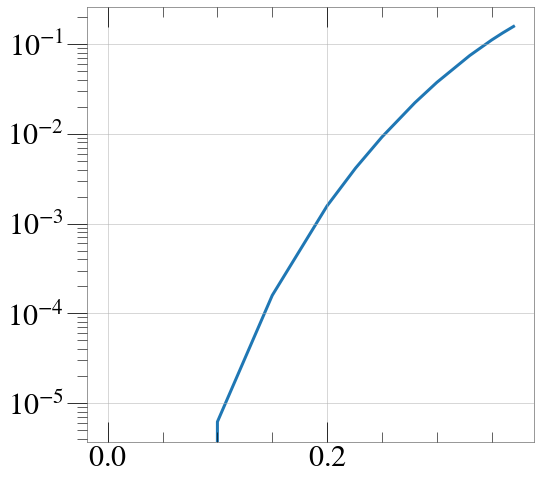

In [51]:
plt.figure(figsize=(8, 8))
plt.plot(ells, mismatches)
plt.yscale('log')
plt.show()

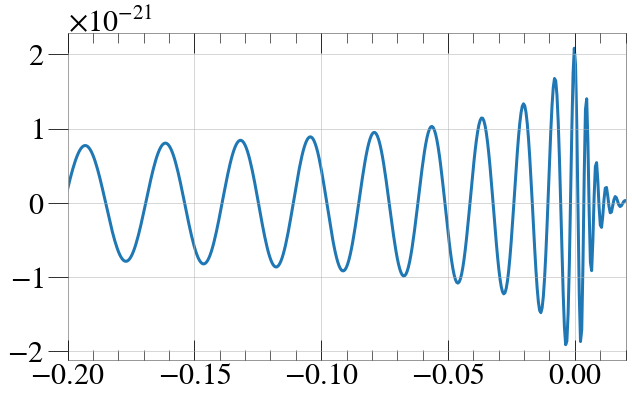

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(time_gr, h_plus_gr)
plt.xlim(-0.2, 0.02)
plt.show()

Optimize over time and phase shift

In [4]:
def GetFramesData(p):
    
    det = 'H1'
    sH = TimeSeries.read(source = p + '/Frames/' + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = np.array(sH.times)
    
    det = 'L1'
    sL = TimeSeries.read(source = p + '/Frames/' + det + '.gwf', channel=det+":LDAS_STRAIN")
    tL = np.array(sH.times)
    
    return tH, sH, tL, sL

def GetInjectedParameters(p):
    """ Return a dictionary of values from the parameters.json file 
        corresponding to the frames, where p is the path to the file """
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    f.close()
    return params

In [5]:
def GetBilbyParameters(p):
    """ Obtain max likelihood Bilby parameters given what the Bilby Slack said """

    result = bilby.core.result.read_in_result(p + "/outdir/fast_tutorial_result.json")
    maxL_ind = np.argmax(np.array(result.posterior['log_likelihood']))
    maxL_point = result.posterior.iloc[maxL_ind]
    maxP_ind = np.argmax(np.array(result.posterior['log_likelihood'] + result.posterior['log_prior']))
    maxP_point = result.posterior.iloc[maxP_ind]

    return maxP_point

def GetMultipleBilbyParameters(p, n_points):
    """ Obtain n_points max likelihood Bilby parameters """

    result = bilby.core.result.read_in_result(p + "/outdir/fast_tutorial_result.json")
    values = np.array(result.posterior['log_likelihood'] + result.posterior['log_prior'])
    
    sorted_indices = (values.argsort()[::-1])[0:n_points]
    result_points = [result.posterior.iloc[index] for index in sorted_indices]

    return result_points

def GetBilbyDict(BilbyRes):
    """ Convert a Bilby max likelihood result into a dictionary of parameters 
        that we can pass into the surrogate model """
    
    BilbyDict = {}
    BilbyDict['dt'] = 1.0/2048.
    
    ## Reciprocal of the mass ratio 
    q = 1.0/BilbyRes['mass_ratio']
    BilbyDict['q'] = q
    
    m_1, m_2, mass = MassParameters(BilbyRes)
    BilbyDict['mass'] = mass
    BilbyDict['m_1'] = m_1
    BilbyDict['m_2'] = m_2
    
    BilbyDict['dist_mpc'] = BilbyRes['luminosity_distance'] 
    BilbyDict['f_low'] = 0.0
    BilbyDict['phi'] = BilbyRes['phase'] ## phase of coalescence (at some fiducial time)
    
    ## Spin computations
    chi_1, chi_2, theta = Compute_Spins(BilbyRes)

    BilbyDict['a_1'] = chi_1
    BilbyDict['a_2'] = chi_2
    chi_eff = EffectiveSpin(BilbyDict)
    BilbyDict['chi_eff'] = chi_eff
    
    BilbyDict['theta'] = theta ## Theta from the spin computation conventions
    
    BilbyDict['ra'] = BilbyRes['ra']
    BilbyDict['dec'] = BilbyRes['dec']
    BilbyDict['geocent_time'] = BilbyRes['geocent_time']
    BilbyDict['pol'] = BilbyRes['psi'] ## polarization (angle on the sky of the pericenter wrt to interferometer -- degenerate for circular orbits
    
    return BilbyDict


In [73]:
#F_Ref_Opt = GenerateOptimalFrequencyDictionary()

25 0p0
25 0p25
25 0p3
25 0p35
25 0p37
75 0p0
75 0p2
75 0p25
75 0p28
75 0p3
75 0p33
75 0p35
75 0p36
75 0p37
125 0p0
125 0p25
125 0p3
125 0p35
125 0p37


/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1515: UserWarning: Spin magnitude of BhB=0.8296 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiBmag, chiMax))
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1512: UserWarning: Spin magnitude of BhA=0.8857 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiAmag, chiMax))
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1515: UserWarning: Spin magnitude of BhB=0.9893 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiBmag, chiMax))
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1512: UserWarning: Spin magnitude of BhA=0.9654 is outside training range: chi<=0.8010
  'training range: chi<=%.4f'%(chiAmag, chiMax))
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/surrogate.py:1515: UserWarning: Spin magnitude of BhB=0.988

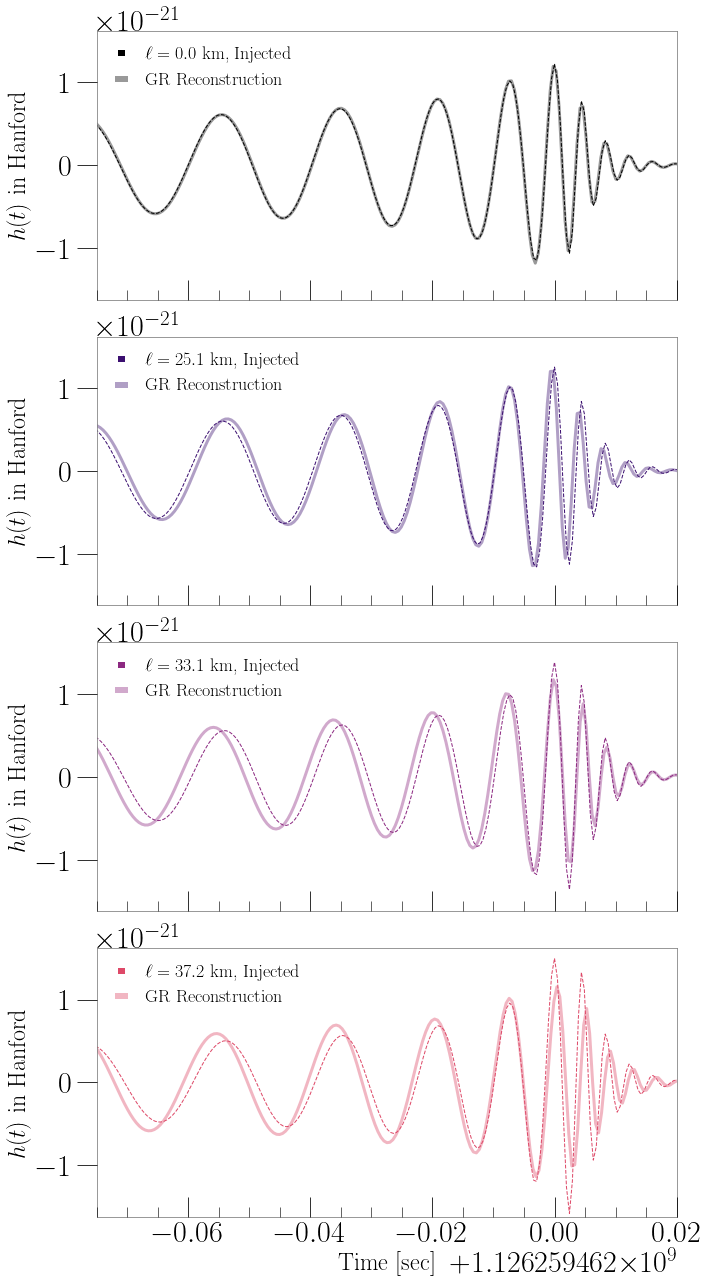

In [37]:
def PlotReconstructionsPanels():
    """ Plot Bilby reconstructed waveforms for a variety of Bilby runs"""
    
    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    SNR = '75'
    
    ## Grab the mass from the truth dictionary
    p_gr = base_dir + 'NoTilt_dCS_0p0_' + SNR + '/'
    TruthDict = GetInjectedParameters(p_gr)
    mass = TruthDict['mass']
    
    ells = ['0p0', '0p25', '0p33', '0p37']
    
    cs = ['black'] + sns.color_palette('magma', n_colors=len(ells))
    
    fig, axes = plt.subplots(len(ells), figsize=(10,18), sharex = True, sharey = True)
    
    for ell, color, ax in zip(ells, cs, axes):

        p = base_dir + 'NoTilt_dCS_' + ell + '_' + SNR + '/'

        timeH, strainH, timeL, strainL = GetFramesData(p)
        timeH_bil, strainH_bil, timeL_bil, strainL_bil, bilby_dict = BilbyReconstruction(p)

        ax.plot(timeH, strainH, lw = 1.0, color = color, ls = '--', label = '$\ell = %.1f$ km, Injected' % EllinKm(ell, mass))
        ax.plot(timeH_bil, strainH_bil, lw = 3.0, color = color, alpha = 0.4, label = 'GR Reconstruction')
        
        ax.legend(fontsize=18, loc = 'upper left', frameon=False)
        ax.set_ylabel(r'$h(t)$ in Hanford')
        ax.tick_params(axis='x', which='both', bottom=True, top=False) 
        ax.set_ylim(-1.62e-21, 1.62e-21)
        ax.grid()
        
    plt.xlim(-0.075 + TruthDict['t_gps'], 0.02 + TruthDict['t_gps'])
    plt.xlabel('Time [sec]')
    plt.tight_layout()
    plt.savefig('BilbyReconstructions.pdf')
    plt.show()

    
PlotReconstructionsPanels()

In [ ]:
def PlotReconstructionsOverlaps():
    """ Compute the Bilby overlaps and plot as a function of ell """
    
    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'

    p_gr = base_dir + 'NoTilt_dCS_0p0_125/'
    TruthDict = GetInjectedParameters(p_gr)
    mass = TruthDict['mass']

    ells = ["0p0", "0p25", "0p3", "0p35", "0p37"]
    ell_vals = [EllinKm(ell, mass) for ell in ells]

    SNRs = ['25', '75', '125']
    snr_overlaps = []

    for i, SNR in enumerate(SNRs):
        ## Iterate over SNR values

        print(SNR)
        overlaps = []

        for ell in ells:
            ## Iterate over ell values
            print(ell)

            p = base_dir + 'NoTilt_dCS_' + ell + '_' + SNR + '/'

            timeH, strainH, timeL, strainL = GetFramesData(p)
            timeH_bil, strainH_bil, timeL_bil, strainL_bil, bilby_dict = BilbyReconstruction(p)

            #overlap = ComputeMultiDetectorOverlap(timeH_bil, strainH_bil, timeL_bil, strainL_bil, \
            #                        timeH, strainH, timeL, strainL)
            overlap = ComputeOverlap(timeH_bil, strainH_bil, timeH, strainH)
            overlaps.append(overlap)

        snr_overlaps.append(overlaps)
        
    
    plt.figure(figsize=(10,5))
    colors = ['pink', 'orange', 'red']
    deltas = 1.0 - np.array(snr_overlaps)
    
    for i, SNR in enumerate(SNRs):
        plt.plot(np.array(ell_vals)**4, deltas[i], '--o', label = SNR, markersize = 10, color = colors[i])

    plt.grid()
    leg = plt.legend(title = 'Injected SNR', frameon = False, loc = 'lower right')
    plt.setp(leg.get_title(),fontsize=20)
    plt.ylabel(r'$\Delta_\mathrm{GR, Injected}$', fontsize=24)
    plt.xlabel(r'($\ell$ [km])${}^4$', fontsize=24)
    plt.tight_layout()
    plt.yscale('log')
    plt.savefig('BilbyOverlap.pdf')
    plt.show() 

    
PlotReconstructionsOverlaps()

In [ ]:
def PlotMultipleReconstructions():

    plt.figure(figsize=(16,8))
    
    base_dir = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    
    ## Injected parameters
    p = base_dir + 'NoTilt_dCS_0p37_75'
    truth_dict = GetInjectedParameters(p)
    print(truth_dict)
    timeH, strainH, timeL, strainL = GetFramesData(p)
    
    ## Plot multiple reconstructed waveforms
    bilby_results = GetMultipleBilbyParameters(p, 50)

    for bilby_result in bilby_results:
        
        bilby_dict = GetBilbyDict(bilby_result)
        bilby_dict['phi'] = bilby_dict['phi']
        time_bil, h_plus_bil, h_cross_bil, amp_bil = EvaluateSurrogate(sur, bilby_dict) 
        timeH_bil, strainH_bil, timeL_bil, strainL_bil = ProjectGivenGeocenterTime(time_bil, h_plus_bil, h_cross_bil, bilby_dict)

        plt.plot(timeH_bil, strainH_bil, lw = 0.5, color = 'gray', alpha = 0.2)

    ## Plot GR waveform   
    plt.plot(timeH, strainH, lw = 2.0, color = '#1ae863', label = 'Injection', ls = '--')
    
    plt.xlim(-0.15 + truth_dict['t_gps'], 0.033 + truth_dict['t_gps'])
    plt.xlabel('Time [sec]')
    plt.ylabel(r'$h(t)$ in Hanford')
    legend = plt.legend(fontsize=18, loc = 'lower left', frameon=True)
    plt.grid()
    plt.tight_layout()
    plt.savefig('BilbyMultipleReconstructions.pdf')
    plt.show()

#PlotMultipleReconstructions()

In [ ]:
def SurrogateVariousSpins():
    """ Plot surrogate waveforms for different values of the spins a_1 and a_2 while keeping the mass ratio constant
        and ensuring that chi_eff ~ 0"""
    
    
    ## Plot for the actual bilby spin values as they change
    ## Plot the actual Bilby reconstructions
    
    desired_snr = 75
    
    plt.figure(figsize=(14, 8))
    
    a_1s = [0.0, 0.25, 0.5, 0.75]
    cs = ['black'] + sns.color_palette('magma', n_colors=len(a_1s))
    
    for a_1, color in zip(a_1s, cs): 
    
        a_2 = a_1 / 1.2212532137858916 ## mass ratio
        
        params_dict = {'dt' : 1/2048, 't_gps' : 1126259462.0, 'peak_time_in_segment' : 8.0, 'segment_length' : 16.0, \
               'dist_mpc' : 400.0, 'mass' : 68.0, 'q' : 1.2212532137858916, \
               'a_1' : [0, 0, a_1], 'a_2' : [0,0, -a_2], \
               'f_low' : 25, 'theta' : pi, 'phi' : 0, \
               'ra' : 1.952318922, 'dec' : -1.26967171703, 'pol' : 0.824043851821, 'geocent_time': 1126259461.9841547, \
                'm_1': 37.38665093292035, 'm_2': 30.61334906707965, 'mass_ratio': 0.8188310079446952, 'chirp_mass': 29.422167356249002}
        
        
        chi_eff = EffectiveSpin(params_dict)
        print("Effective spin: ", chi_eff)
    
        time, h_plus, h_cross, amp = EvaluateSurrogate(sur, params_dict)
        
        ## Now compute the SNR in the detectors and scale accordingly
        current_dist = params_dict['dist_mpc']
        timeH, strainH, timeL, strainL = ProjectGivenGeocenterTime(time, h_plus, h_cross, params_dict)
        strainH, strainL, params_dict = TargetSNR(timeH, strainH, timeL, strainL, params_dict, desired_snr)
        updated_dist = params_dict['dist_mpc']
        #h_plus = h_plus * current_dist / updated_dist
        #h_cross = h_cross * current_dist / updated_dist

        plt.plot(timeH, strainH, label = '$a_1 = %.3f, a_2 = %.3f$' % (a_1, a_2), lw = 1.0, color = color)
        

    plt.xlim(-0.15 +  params_dict['t_gps'], 0.02 +  params_dict['t_gps'])
    plt.xlabel('Time [sec]')
    plt.ylabel(r'$h(t)$ in Hanford')
    legend = plt.legend(fontsize=24, loc = 'lower left', ncol=2, frameon=False)
    plt.grid()
    plt.show()
    
#SurrogateVariousSpins()